<a href="https://colab.research.google.com/github/criscarmor/TFG-CCM/blob/main/DEFINITIVO_Predicci%C3%B3n_espacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este Notebook se encarga de generar los datasets necesarios para la estimación espacial

Para comenzar hay que subir 2 archivos:

*   **X_data_final.csv** (donde X indica el contaminante)
*   **clima_data_final.csv** (archivo con los datos de clima horarios)

En la primera línea de código, elegir la estación objetivo de estudio, el contaminante, y las estaciones vecinas. Además, hay que excluir explícitamente alguna estación si nos interesa incluirla. Hay que tener en cuenta que no todas las estaciones están disponibles para todos los contaminantes.

*   **NO2**: [9, 10, 15, 16, 17, 18, 19]
*   **O3**: [9, 15, 17, 18, 19]
*   **SO2**: [9, 10, 16, 18, 19]
*   **PM10**: [9, 15, 16, 18]
*   **PM25**: [9, 10, 15]



In [ ]:
contaminante = 'PM10'
target = 9
#neigh = [9,10,15,16]
neigh = [15,16,18]
excluir = [17]

In [ ]:
def calcular_RMSu(parametros, media, std):
  primero = (1-parametros[2]**2)*(media**2 + std**2)
  segundo = (parametros[2]**2)*(parametros[1]**2)
  return parametros[0]*np.sqrt(primero + segundo)


In [ ]:
parametros = {
    'NO2': [0.24, 200, 0.2],
    'O3' : [0.18, 120, 0.79],
    'PM10' : [0.28, 50, 0.25],
    'PM25' : [0.36, 25, 0.50]
}

In [ ]:
def merge_por_estacion(df_contaminacion, df_clima):

    estaciones = df_contaminacion['ESTACION'].unique()
    resultados = {}

    for est in estaciones:
        df_est = df_contaminacion[df_contaminacion['ESTACION'] == est]
        df_merged = df_est.merge(df_clima, left_index=True, right_index=True, how='inner')
        df_merged.drop(columns=['ESTACION'], inplace=True)
        resultados[est] = df_merged

    return resultados

#Carga de datos


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv(contaminante + "_data_final.csv", index_col=0, parse_dates=True)
df

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2016-01-01 00:00:00,9.0,27.88,0.000000,1.000000,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 01:00:00,9.0,36.90,0.258819,0.965926,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 02:00:00,9.0,27.06,0.500000,0.866025,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 03:00:00,9.0,18.04,0.707107,0.707107,-0.433884,-0.900969,5.000000e-01,0.866025
2016-01-01 04:00:00,9.0,16.40,0.866025,0.500000,-0.433884,-0.900969,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,18.0,27.56,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,18.0,31.80,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,18.0,38.16,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_clima = pd.read_csv("clima_data_final.csv", index_col=0, parse_dates=True)
df_clima

,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
FECHA_HORA,,,,,,,
2014-01-02 00:00:00,13.900000,13.3,97.000000,11.2,0.0,-6.427876e-01,-0.766044
2014-01-02 01:00:00,13.966667,13.3,96.666667,12.4,0.0,-6.838732e-01,-0.724959
2014-01-02 02:00:00,14.033333,13.3,96.333333,13.6,0.0,-7.249588e-01,-0.683873
2014-01-02 03:00:00,14.100000,13.3,96.000000,14.8,0.0,-7.660444e-01,-0.642788
2014-01-02 04:00:00,14.000000,14.0,100.000000,13.0,0.0,-5.000000e-01,-0.866025
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,9.500000,9.5,100.000000,7.6,0.0,5.000000e-01,0.866025
2023-12-31 20:00:00,9.300000,9.3,100.000000,3.6,0.0,1.736482e-01,0.984808
2023-12-31 21:00:00,7.900000,7.9,100.000000,5.4,0.0,-2.449294e-16,1.000000


In [ ]:
df_estaciones = merge_por_estacion(df, df_clima)

#Unificar

In [ ]:
df_estaciones_filtrado = {
    k: v for k, v in df_estaciones.items()
    if k not in excluir
}

In [ ]:
dfs_conc = []

for nombre_estacion, df in df_estaciones_filtrado.items():
    # Extraer solo la columna de concentración y renombrar
    serie = df[['CONCENTRACION']].copy()
    serie.columns = [nombre_estacion]
    dfs_conc.append(serie)


df_unificado = pd.concat(dfs_conc, axis=1, join='inner')

In [ ]:
df_unificado

,9.0,15.0,16.0,18.0
FECHA_HORA,,,,
2016-01-01 00:00:00,27.88,65.55,43.70,64.60
2016-01-01 01:00:00,36.90,52.25,36.80,24.70
2016-01-01 02:00:00,27.06,40.85,17.25,9.50
2016-01-01 03:00:00,18.04,31.35,11.50,6.65
2016-01-01 04:00:00,16.40,28.50,10.35,6.65
...,...,...,...,...
2023-12-31 19:00:00,46.20,70.18,28.62,27.56
2023-12-31 20:00:00,35.70,83.49,28.62,31.80
2023-12-31 21:00:00,33.60,56.87,30.74,38.16


In [ ]:
X_vecinas = df_unificado[neigh]
y_target = df_unificado[[target]]

In [ ]:
df_target = df_estaciones_filtrado[target].copy()
features_target = df_target.drop(columns=["CONCENTRACION"])
features_target = features_target.loc[X_vecinas.index]

In [ ]:
X_total = pd.concat([X_vecinas, features_target], axis=1)

In [ ]:
X_total

,15.0,16.0,18.0,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
FECHA_HORA,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,65.55,43.70,64.60,0.000000,1.000000,-0.433884,-0.900969,5.000000e-01,0.866025,15.0,15.0,100.0,0.0,0.0,0.000000e+00,1.000000
2016-01-01 01:00:00,52.25,36.80,24.70,0.258819,0.965926,-0.433884,-0.900969,5.000000e-01,0.866025,15.6,15.4,99.0,0.0,0.0,0.000000e+00,1.000000
2016-01-01 02:00:00,40.85,17.25,9.50,0.500000,0.866025,-0.433884,-0.900969,5.000000e-01,0.866025,15.6,15.6,100.0,1.8,0.0,1.736482e-01,-0.984808
2016-01-01 03:00:00,31.35,11.50,6.65,0.707107,0.707107,-0.433884,-0.900969,5.000000e-01,0.866025,15.7,14.9,96.0,5.4,0.0,1.224647e-16,-1.000000
2016-01-01 04:00:00,28.50,10.35,6.65,0.866025,0.500000,-0.433884,-0.900969,5.000000e-01,0.866025,15.9,15.7,99.0,9.4,0.0,-1.736482e-01,-0.984808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,70.18,28.62,27.56,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000,9.5,9.5,100.0,7.6,0.0,5.000000e-01,0.866025
2023-12-31 20:00:00,83.49,28.62,31.80,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000,9.3,9.3,100.0,3.6,0.0,1.736482e-01,0.984808
2023-12-31 21:00:00,56.87,30.74,38.16,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000,7.9,7.9,100.0,5.4,0.0,-2.449294e-16,1.000000


In [ ]:
n = len(X_total)

cutoff = int(n * 0.8)

X_train = X_total.iloc[:cutoff]
X_test = X_total.iloc[cutoff:]

y_train = y_target.iloc[:cutoff]
y_test = y_target.iloc[cutoff:]


In [ ]:
X_test

,15.0,16.0,18.0,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
FECHA_HORA,,,,,,,,,,,,,,,,
2023-04-03 00:00:00,0.00,11.66,12.72,0.000000,1.000000,0.000000,1.00000,8.660254e-01,-0.5,14.5,0.1,28.0,13.0,0.0,7.660444e-01,0.642788
2023-04-03 01:00:00,0.00,10.60,10.60,0.258819,0.965926,0.000000,1.00000,8.660254e-01,-0.5,12.6,-0.4,35.0,9.4,0.0,5.000000e-01,0.866025
2023-04-03 02:00:00,0.00,10.60,9.54,0.500000,0.866025,0.000000,1.00000,8.660254e-01,-0.5,11.9,-0.7,37.0,0.0,0.0,0.000000e+00,1.000000
2023-04-03 03:00:00,0.00,12.72,8.48,0.707107,0.707107,0.000000,1.00000,8.660254e-01,-0.5,10.7,-0.5,44.0,3.6,0.0,6.427876e-01,0.766044
2023-04-03 04:00:00,0.00,12.72,7.42,0.866025,0.500000,0.000000,1.00000,8.660254e-01,-0.5,11.9,-1.1,35.0,13.0,0.0,7.660444e-01,0.642788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,70.18,28.62,27.56,-0.965926,0.258819,-0.781831,0.62349,-2.449294e-16,1.0,9.5,9.5,100.0,7.6,0.0,5.000000e-01,0.866025
2023-12-31 20:00:00,83.49,28.62,31.80,-0.866025,0.500000,-0.781831,0.62349,-2.449294e-16,1.0,9.3,9.3,100.0,3.6,0.0,1.736482e-01,0.984808
2023-12-31 21:00:00,56.87,30.74,38.16,-0.707107,0.707107,-0.781831,0.62349,-2.449294e-16,1.0,7.9,7.9,100.0,5.4,0.0,-2.449294e-16,1.000000


In [ ]:
y_test

,9.0
FECHA_HORA,
2023-04-03 00:00:00,13.65
2023-04-03 01:00:00,4.20
2023-04-03 02:00:00,12.60
2023-04-03 03:00:00,15.75
2023-04-03 04:00:00,30.45
...,...
2023-12-31 19:00:00,46.20
2023-12-31 20:00:00,35.70
2023-12-31 21:00:00,33.60


In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid = {
    'svr__C': [0.1, 1],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto'],
    'svr__kernel': ['rbf']
}


In [ ]:
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=1)
grid.fit(X_train, y_train.values.ravel())


Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [ ]:
print("Mejores parámetros:", grid.best_params_)

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print(f"SVM — RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")


In [ ]:
n = 168
y_real_48 = y_test.iloc[:n]
y_pred_48 = y_pred_best[:n]
fechas_48 = y_real_48.index

plt.figure(figsize=(14, 5))
plt.plot(fechas_48, y_real_48.values, label='Real', marker='o', markersize = 4)
plt.plot(fechas_48, y_pred_48, label='Predicción SVM', marker='x', markersize = 4)
plt.title('Predicción vs Realidad (48 horas)')
plt.xlabel('Fecha-Hora')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBRegressor

# Modelo base
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Malla de búsqueda con subsample fijo en 1.0
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Búsqueda
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=1
)

# Entrenamiento
grid_xgb.fit(X_train, y_train.values.ravel())

# Evaluación
print("Mejores parámetros:", grid_xgb.best_params_)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")



Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsamp

KeyboardInterrupt: 

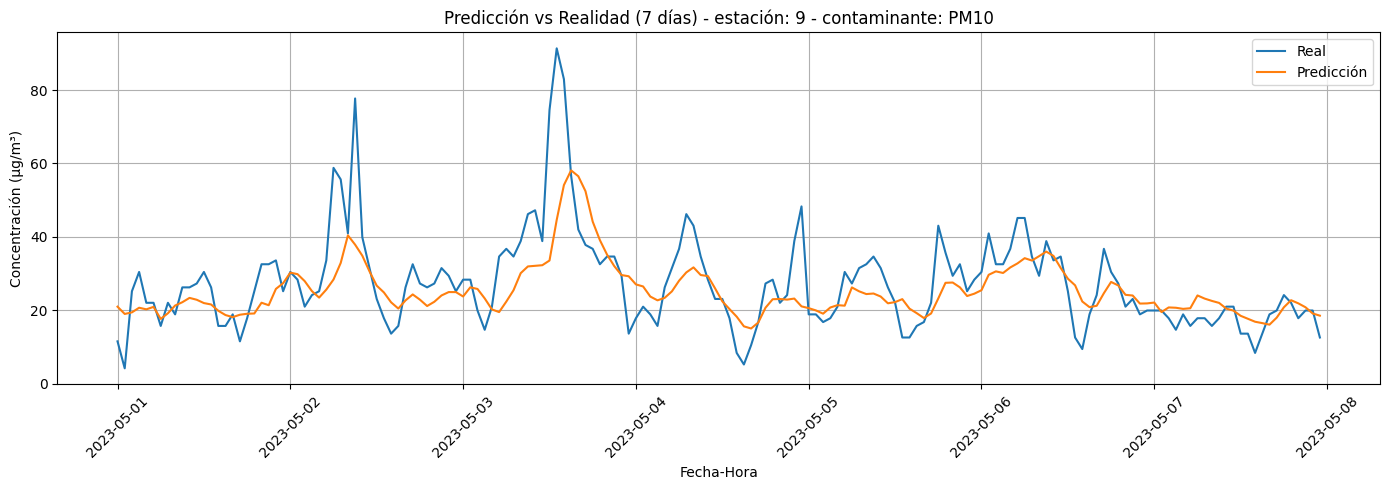

In [ ]:
dias = 7
n = dias * 24
y_real_48 = y_test.iloc[2*n:3*n]
y_pred_48 = y_pred_xgb[2*n:3*n]
fechas_48 = y_real_48.index

plt.figure(figsize=(14, 5))
plt.plot(fechas_48, y_real_48.values, label='Real')
plt.plot(fechas_48, y_pred_48, label='Predicción')
plt.title('Predicción vs Realidad ('+ str(dias) +' días)' + ' - estación: ' + str(target) + ' - contaminante: ' + contaminante)
plt.xlabel('Fecha-Hora')
plt.ylabel('Concentración (μg/m³)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Obtener importancias y nombres
importancias = best_xgb.feature_importances_
nombres = X_train.columns

# Crear DataFrame
df_importancia = pd.DataFrame({
    'feature': nombres,
    'importance': importancias
}).sort_values(by='importance', ascending=False)


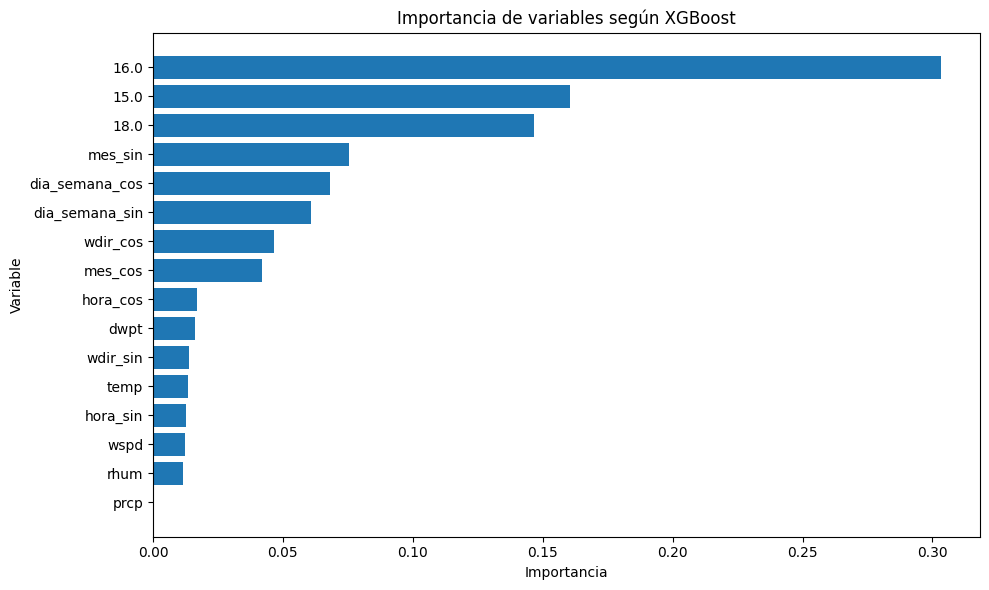

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de variables según XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [ ]:
# Red con 1 capa oculta de 10 neuronas
ffnn_1 = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(10,), activation='relu', max_iter=500, random_state=42)
)

# Red con 2 capas ocultas
ffnn_2 = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', max_iter=500, random_state=42)
)

# Red con 3 capas ocultas
ffnn_3 = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(10, 10, 10), activation='relu', max_iter=500, random_state=42)
)


In [ ]:
modelos = {'FFNN-1': ffnn_1, 'FFNN-2': ffnn_2, 'FFNN-3': ffnn_3}
resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train.values.ravel())
    y_pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    RMSu = calcular_RMSu(parametros[contaminante], np.mean(y_test), np.std(y_test))
    MQI = rmse/(2*RMSu)

    resultados[nombre] = {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MQI': MQI}


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis

In [ ]:
df_ffnn = pd.DataFrame(resultados).T
print(df_ffnn)


            RMSE       MAE        R²                             MQI
FFNN-1  9.200958  6.329703  0.680432  9.0    0.497033
dtype: float64
FFNN-2  9.515028  6.471222  0.658243  9.0    0.513999
dtype: float64
FFNN-3  9.395328  6.356296  0.666787  9.0    0.507533
dtype: float64


In [ ]:
# Red con 1 capa oculta de 10 neuronas
ffnn_1 = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(10,), activation='logistic', max_iter=500, random_state=42)
)

# Red con 2 capas ocultas
ffnn_2 = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(10, 10), activation='logistic', max_iter=500, random_state=42)
)

# Red con 3 capas ocultas
ffnn_3 = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(10, 10, 10), activation='logistic', max_iter=500, random_state=42)
)


In [ ]:
modelos = {'FFNN-1': ffnn_1, 'FFNN-2': ffnn_2, 'FFNN-3': ffnn_3}
resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train.values.ravel())
    y_pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    RMSu = calcular_RMSu(parametros[contaminante], np.mean(y_test), np.std(y_test))
    MQI = rmse/(2*RMSu)

    resultados[nombre] = {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MQI': MQI}

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis

In [ ]:
df_ffnn = pd.DataFrame(resultados).T
print(df_ffnn)

            RMSE       MAE        R²                              MQI
FFNN-1  5.973002  4.234934  0.766492  19.0    0.283935
dtype: float64
FFNN-2  6.369286  4.413377   0.73448  19.0    0.302773
dtype: float64
FFNN-3  6.121679  4.311725  0.754723  19.0    0.291003
dtype: float64
